# Una red neuronal convolucional simple

- 2 capas de convolucion + ReLU + Max Pooling
- 2 capas totalmente conectadas

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

from tensorflow.python.framework import ops
ops.reset_default_graph()
session = tf.Session()

In [33]:
mnist = input_data.read_data_sets("MNIST_data", one_hot= False)

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


In [34]:
train_xdata = np.array([np.reshape(x, (28,28)) for x in mnist.train.images])
test_xdata = np.array([np.reshape(x, (28,28)) for x in mnist.test.images])
train_labels = mnist.train.labels
test_labels = mnist.test.labels

In [36]:
batch_size = 100

evaluation_size = 500
image_width = train_xdata[0].shape[0]  #toma el valor del ancho de la primera imagen del dataset de train
image_height = train_xdata[0].shape[1] #toma el valor de la altura de la primera imagen del dataset de train
target_size = max(train_labels)+1      # valores desde 0 a 9, en total 10 targets
num_chanels = 1                        # numero de canales, en este caso es 1 porque las imagenes son en blanco y negro.


conv1_features = 25                    # numero de rasgos despues de la primera convolucion
conv2_features = 50                    # numero de rasgos despues de la segunda convolucion
max_pool_size1 = 2                     # ventana de 2x2 para el maxpool
max_pool_size2 = 2                     # ventana de 2x2 para el maxpool
full_connected_size1 = 100             # 100 nodos

In [37]:
x_input_shape = (batch_size, image_width, image_height, num_chanels) # (numero de elementos de la muestra, ancho de la imagen, alto de la imagen, numero de canales)
x_input = tf.placeholder(shape = x_input_shape, dtype=tf.float32)
y_target = tf.placeholder(shape = (batch_size), dtype=tf.int32) #int32 porque lo que se predice son numeros enteros (0,1,2,3,4,5,6,7,8,9)

eval_input_shape = (evaluation_size, image_width, image_height, num_chanels) # (numero de elementos de la muestra, ancho de la imagen, alto de la imagen, numero de canales)
eval_input = tf.placeholder(shape=eval_input_shape, dtype=tf.float32)
eval_target = tf.placeholder(shape=evaluation_size, dtype=tf.float32)

In [38]:
conv1_weight = tf.Variable(tf.truncated_normal([4,4,num_chanels,conv1_features], stddev=0.1, dtype=tf.float32)) #matrices de 4x4, con el numero de canales establecido y con los features de salida establecidos
conv1_bias = tf.Variable(tf.zeros([conv1_features], dtype=tf.float32)) #bias para los 25 datos de salida

conv2_weight = tf.Variable(tf.truncated_normal([4,4,conv1_features,conv2_features], stddev=0.1, dtype=tf.float32)) #matrices de 4x4, con el numero de deatures de salida de la capa anteiror que son 25,y la salida son son los indicados en conv2_features que son 50
conv2_bias = tf.Variable(tf.zeros([conv2_features], dtype=tf.float32)) #bias para los 50 datos de salida

In [39]:
resulting_width = image_width // (max_pool_size1*max_pool_size2)
resulting_heigth = image_height // (max_pool_size1*max_pool_size2)
full1_input_size = resulting_width*resulting_heigth*conv2_features

full1_weight = tf.Variable(tf.truncated_normal([full1_input_size, full_connected_size1], stddev=0.1,dtype=tf.float32)) # la entrada es: los nodos resultantes despues de las 2 convoluciones(estos son calculados en la linea anterior, y la salida= 100 nodos correspondientes a full_connected_size1
full1_bias = tf.Variable(tf.truncated_normal([full_connected_size1], stddev=0.1,dtype=tf.float32)) # bias para 100 nodos correspondientes a full_connected_size1

full2_weight = tf.Variable(tf.truncated_normal([full_connected_size1, target_size], stddev=0.1,dtype=tf.float32)) # la entrada es la salida de la capa anterior, y la salida= 10 nodos correspondientes a target_size
full2_bias = tf.Variable(tf.truncated_normal([target_size], stddev=0.1,dtype=tf.float32)) # bias para 10 nodos correspondientes a target_size

In [40]:
def my_conv_neural_net(input_data):
    #primera capa: convolucion+relu+maxpool
    conv1 = tf.nn.conv2d(input_data, conv1_weight, strides=[1,1,1,1], padding="SAME")
    relu1 = tf.nn.relu(tf.nn.bias_add(conv1, conv1_bias))
    max_pool1 = tf.nn.max_pool(relu1, ksize=[1,max_pool_size1,max_pool_size2,num_chanels], 
                                      strides=[1,max_pool_size1,max_pool_size2,num_chanels],
                                      padding="SAME")
    #segunda capa: convolucion+relu+maxpool
    conv2 = tf.nn.conv2d(max_pool1, conv2_weight, strides=[1,1,1,1], padding="SAME")
    relu2 = tf.nn.relu(tf.nn.bias_add(conv2, conv2_bias))
    max_pool2 = tf.nn.max_pool(relu2, ksize=[1,max_pool_size1,max_pool_size2,num_chanels], 
                                      strides=[1,max_pool_size1,max_pool_size2,num_chanels],
                                      padding="SAME")
    #operacion de flatening para aplanar la imagen en un vector
    final_conv_shape = max_pool2.get_shape().as_list()
    final_shape = final_conv_shape[1]*final_conv_shape[2]*final_conv_shape[3] #final_conv_shape[1] corresponde a la anchura de la imagen, final_conv_shape[2] corresponde a la altura de la imagen, y final_conv_shape[3] corresponde al numero de canales
    flat_output = tf.reshape(max_pool2, [final_conv_shape[0], final_shape])   #final_conv_shape[0] corresponde al tamaño de la muestra
    #tercera capa: capa totalmente conectada 1
    fully_connected_1 = tf.nn.relu(tf.add(tf.matmul(flat_output,full1_weight), full1_bias))
    #cuerta capa: capa totalmente conectada 2
    fully_connected_2 = tf.nn.relu(tf.add(tf.matmul(fully_connected_1,full2_weight), full2_bias))
    
    return fully_connected_2

In [41]:
model_output = my_conv_neural_net(x_input)  # recordar que "model_output" contendra probabilidades
test_model_output = my_conv_neural_net(eval_input) # lo mismo con aqui

In [42]:
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=model_output, labels=y_target))

In [43]:
prediction = tf.nn.softmax(model_output) # "prediction" la funcion softmax convierte las probabiliades devueltas por el "model_output" en los numeros de 0 a 9 en este caso
test_prediction = tf.nn.softmax(test_model_output) #lo mismo aqui

In [44]:
def get_accuracy(logits, targets):                                
    batch_predictions = np.argmax(logits, axis=1)                 # los logits ya vendran a que numero se ajusta entre 0 y 9, se guardan las predicciones en batch_predictions
    num_corrects = np.sum(np.equal(batch_predictions, targets))   # se compara las predicciones con los valores reales, si son iguales, devuelve 1, si son diferentes devuelve 0
    return 100.0*num_corrects/batch_predictions.shape[0]          # porcentaje de aciertos = 100 * numero de predicciones correctas / cantidad de imagenes

In [45]:
optimizador = tf.train.MomentumOptimizer(learning_rate=0.005, momentum=0.9)
train_step = optimizador.minimize(loss)

In [46]:
init = tf.global_variables_initializer()
session.run(init)

In [47]:
train_loss = []
train_acc = []
test_acc = []
i_vals = []

for i in range(500):
    rand_idx = np.random.choice(len(train_xdata), size=batch_size)
    rand_x = train_xdata[rand_idx]
    rand_x = np.expand_dims(rand_x, 3) # se agrega la dimension en la posicion 4, correspondiente a los canales de color
    rand_y = train_labels[rand_idx]
    
    train_dict = {x_input:rand_x, y_target:rand_y}
    session.run(train_step, feed_dict=train_dict)
    temp_train_loss, temp_train_preds = session.run([loss, prediction], feed_dict=train_dict)
    
    temp_train_acc = get_accuracy(temp_train_preds, rand_y)
    
    if(i+1)%5==0: ## cada 5 iteraciones se hace los siguiente
        rand_idx_eval = np.random.choice(len(test_xdata), size=evaluation_size)
        rand_x_eval = test_xdata[rand_idx_eval]
        rand_x_eval = np.expand_dims(rand_x_eval, 3)  # se agrega la dimension en la posicion 4, correspondiente a los canales de color
        rand_y_eval = test_labels[rand_idx_eval]
        
        test_dict = {eval_input:rand_x_eval, eval_target:rand_y_eval}
        temp_test_preds = session.run(test_prediction, feed_dict=test_dict)
        temp_test_acc = get_accuracy(temp_test_preds, rand_y_eval)
        
        i_vals.append(i+1)
        train_loss.append(temp_train_loss)
        train_acc.append(temp_train_acc)
        test_acc.append(temp_test_acc)
        
        acc_and_loss = [(i+1), temp_train_loss, temp_train_acc, temp_test_acc]
        acc_and_loss = [np.round(x,3) for x in acc_and_loss]
        print("iteracion {}. Train Loss: {:.3f}. Train Acc: {:.3f}. Test Acc: {:.3f}".format(*acc_and_loss))
    

iteracion 5. Train Loss: 2.340. Train Acc: 9.000. Test Acc: 13.000
iteracion 10. Train Loss: 2.238. Train Acc: 26.000. Test Acc: 25.200
iteracion 15. Train Loss: 2.203. Train Acc: 35.000. Test Acc: 28.000
iteracion 20. Train Loss: 2.127. Train Acc: 41.000. Test Acc: 37.400
iteracion 25. Train Loss: 2.083. Train Acc: 41.000. Test Acc: 43.200
iteracion 30. Train Loss: 1.985. Train Acc: 41.000. Test Acc: 44.400
iteracion 35. Train Loss: 1.894. Train Acc: 42.000. Test Acc: 46.800
iteracion 40. Train Loss: 1.667. Train Acc: 57.000. Test Acc: 57.600
iteracion 45. Train Loss: 1.430. Train Acc: 65.000. Test Acc: 56.200
iteracion 50. Train Loss: 1.309. Train Acc: 60.000. Test Acc: 60.600
iteracion 55. Train Loss: 1.193. Train Acc: 68.000. Test Acc: 64.600
iteracion 60. Train Loss: 1.078. Train Acc: 67.000. Test Acc: 67.000
iteracion 65. Train Loss: 1.215. Train Acc: 62.000. Test Acc: 73.000
iteracion 70. Train Loss: 1.055. Train Acc: 65.000. Test Acc: 73.400
iteracion 75. Train Loss: 0.863. Tra

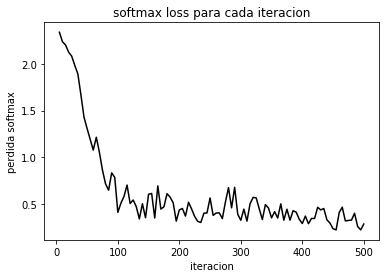

In [48]:
plt.plot(i_vals, train_loss, "k-")
plt.title("softmax loss para cada iteracion")
plt.xlabel("iteracion")
plt.ylabel("perdida softmax")
plt.show()

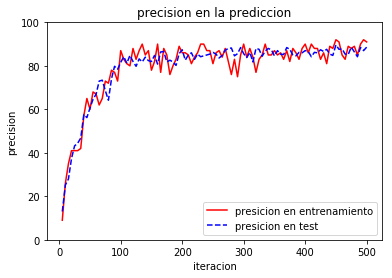

In [52]:
plt.plot(i_vals, train_acc, "r-" ,label="presicion en entrenamiento")
plt.plot(i_vals, test_acc, "b--" ,label="presicion en test")
plt.title("precision en la prediccion")
plt.xlabel("iteracion")
plt.ylabel("precision")
plt.ylim(0,100)
plt.legend(loc = "lower right")
plt.show()

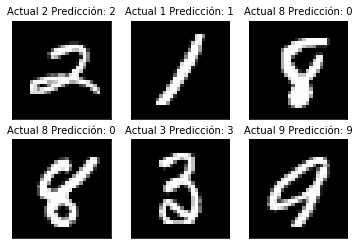

In [58]:
actuals = rand_y[0:6]
predictions = np.argmax(temp_train_preds, axis=1)[0:6]
images = np.squeeze(rand_x[0:6])
nrows = 2
ncols = 3
for i in range(6):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(np.reshape(images[i], [28,28]), cmap="Greys_r")
    plt.title("Actual "+str(actuals[i])+" Predicción: "+str(predictions[i]), fontsize = 10)
    frame=plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)